In [106]:
#%pip install -r requirements.txt --quiet

In [107]:
#Importing libraries
from fredapi import Fred
from IPython.display import HTML
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import requests
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Data preparation

## Data Sources
In our research, we'll be using multiple sources of oil prices data for each of three regions that are discussed in the paper: United States, Russia and Middle East.
Data for US crude oil benchmark West Texas Intermediate (WTI) is coming from two main sources provided by the U.S. government. The first one is the Energy Information Administration (EIA), which gives us information about the crude oil prices, including prices for derived oil products such as gasoline, jet fuel, diesel, heating oil and propane. The second source is the Federal Reserve Economic Data, St. Louis (FRED), maintained by the Federal Reserve Bank of St. Louis. FRED provides economic time-series data.
The time-series is obtained through open data tools and Application Programming Interface (API).

Middle East region is represented by Dubai crude which is commonly used as benchmark for the pricing of Middle Eastern oil, consisting of Dubai, Oman or Abu Dhabi oil.

Russian oil is represented by Urals blend. Data is obtained from Saint Petersburg International Mercantile Exchange https://spimex.com/en/

## Methodology

In order to analyze relations between oil and oil products we identified prices of crude oil and related oil products for three separate locations. Data was collected using RESTful API requests to query the government agencies sources such as EIA and IMF. In Python it's done with help of **requests** library allowing us to make the API calls with specified search parameters(time period, frequency, etc). 

In this study, we'll be focusing on the last five years, starting from October 2018 and going up to October 2023. We chose this time frame to assess how COVID-19, the Russia-Ukraine war, and Israel Hammas-Israel war affected petroleum prices. A five-year period provides a sufficiently large dataset for statistical analysis. This will allow us to perform the Exploratory Data Analysis(EDA) to draw meaningful conclusions about the relationships and correlations within the data. EDA is conducted using Python and popular data analysis libraries such as pandas, matplotlib, and seaborn. 

First, we imported oil prices into a Pandas DataFrame for easier work with tabular data. Next step was to organize data by combining all prices in one dataframe, naming columns and setting proper datatime index to manipulate the time-series. Subsequently, the data was inspected for missing values to ensure data quality. As a part of EDA to visualize the cleaned data, libraries  **matplotlib** and **seaborn** were used to illustrate how oil prices changed over time. The dataset contains prices for crude oil and petroleum products, to describe the relationships between them we conducted a correlation analysis by finding correlation coefficients and building correlation matrix. In our project we've plotted a heatmap to demonstrate how each oil product price correlates with others.

For further statistical analysis we calculated the daily returns on the prices and plotted the returns and the distribution of returns. Using returns instead of prices will make our series stationary, meaning that mean and variance does not change over time.

In addition to EDA we conducted Quantile-Quantile (Q-Q) analysis using **scipy** library to assess whether returns follow a particular theoretical distribution.

In next section we performed ARIMA modeling on crude oil prices to help us understand and predict how oil prices might change over time. By analyzing past prices relationships in different regions and influenced by geopolitical events, the model tries to identify trends and patterns that may repeat in the future. Predicting future prices is crucial for managing risks. We utilized Time Series Analysis module of the **statsmodels** Python package. To ensure the data stationarity we used Augmented Dickey-Fuller Test. Next step to set up the ARIMA model is to identify the optimal model parameters by building the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. We will be using **statsmodels.graphics.tsaplots** library, specifically the plot_acf and plot_pacf functions.

ARIMA models allowed us to run only univariate time series modeling. Since we evaluate multiple variables in our dataset, multivariate techniques must be used to describe the relationships.

Therefore we applied Principal Component Analysis (PCA) to identify the patterns in the data. Machine learning library **scikit-learn** provides methods that we used to implement the PCA on the oil price data.











# Functions

In [151]:
grades = ['WTI', 'Urals', 'OPEC Basket']

# Visualize prices
def plot_prices(dfs):
  """Plot multiple line plots horizontally for crude oil and oil products prices from different regions"""
  # Create a figure and axis
  fig, axes = plt.subplots(1, len(dfs),figsize=(15, 6), sharey=True)

  for df, grade, ax in zip(dfs, grades, axes):
    # Plot the WTI Crude Oil prices dollars per barrel on the left axis 
    ax.set_xlabel('Date')
    ax.set_ylabel(grade + ' Crude $/bbl')

    ax.plot(df.index, df['Crude'], color='k', label=(grade + ' Crude'))

    # Plot the oil products prices on the right axis

    ax2 = ax.twinx()
    ax2.set_ylabel('Oil Prodicts, $/gal')
    for column in df.columns[1:6]:
      ax2.plot(df.index, df[column], label=column)

    # Adjust the legend and show the plot
    
  # fig.legend(loc='upper center', ncol=len(dfs[0].columns))
  plt.tight_layout()
  plt.show()

# Output the dataset
def output_horizontally(dfs, func):
   html = '<div style="display:flex">'
   for df, grade in zip(dfs, grades):
       html += '<div>'
       html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
       html += '<div style="margin-right: 32px">'
       html += func(df).to_html()
       html += '</div></div>'
   html += '</div>'
   display(HTML(html))
   

def print_prices(dfs):  
    """Display prices"""
    output_horizontally(dfs, func=pd.DataFrame.head)  
   

def get_stats(dfs):
   """Function for basic statistics"""
   output_horizontally(dfs, func=pd.DataFrame.describe) 

def check_na(dfs):
   """Check for missing values"""
   output_horizontally(dfs, func=lambda df: df[df.isnull().any(axis=1)])

def fill_na(dfs):
   """Fill missing (NaN) values in a DataFrame with the last observation value"""
   output_horizontally(dfs, func=lambda df: df[df.fillna(method='ffill').isnull().any(axis=1)])    

def calc_returns(dfs):
  """Estimating simple returns"""  
  returns_dfs = []
  html = '<div style="display:flex">'
  for df, grade in zip(dfs, grades):
    df = df.pct_change().dropna()
    html += '<div>'
    html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
    html += '<div style="margin-right: 32px">'
    html += df.head().to_html()
    html += '</div></div>'
    returns_dfs.append(df)
  html += '</div>'
  display(HTML(html))
  
  return returns_dfs

def plot_corr_matrix(dfs):
  """Plot correlation matrices for oil/oil products dataframes"""
  num_plots = len(dfs)

  sns.set_theme(style="white")

  fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True, gridspec_kw={'wspace': 0.5})

  for i, df in enumerate(dfs):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot the correlation matrix using Seaborn heatmap    
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[i])
    axes[i].set_title('Correlation Matrix - ' + grades[i] + ' Crude Oil/Oil Products Relationship')

  # Show the plot 
  plt.show()

def box_plots(dfs):
    """Plot oil prices returns box plots on for each region"""
    num_plots = len(dfs)

    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(15, 5))

    for i, (df, grade) in enumerate(zip(dfs, grades)):
        sns.boxplot(data=df, ax=axes[i])
        axes[i].set_title(f'Box Plot - {grade}')

    plt.tight_layout()
    plt.show()
    
def adf_test(dfs):  
  
  html = '<div>'
  for df, grade in zip(dfs, grades):
    adf_df = pd.DataFrame(index=['ADF Statistic','p-value'])
    for product in df:
       adf_result = adfuller(df[product])
       adf_df[product] = [adf_result[0], adf_result[1]]
    html += '<div>'
    html += '<div style="margin-left: 300px">'+grade+'</div>'
    html += '<div style="margin-bottom: 16px">'    
    html += adf_df.to_html()
    html += '</div></div>'
  html += '</div>'
  display(HTML(html))
  
  
def statistics(dfs):
  # Creating empty DataFrame
# stat_metrics = pd.DataFrame()
  html = '<div style="display:flex">'
  for df, grade in zip(dfs, grades):
    stats_df = pd.DataFrame(index=['Mean','Median','Variance','Skewness','Kurtosis'])
    # Populating the dataframe with metrics
    for product in df:
      stats_df[product] = [df[product].mean(), df[product].median(),df[product].var(), stats.skew(df[product], axis=0, bias=True), stats.kurtosis(df[product], axis=0, bias=True)]
      # stat_metrics['Product'] = [item['name'] for item in products]
      # stat_metrics['Mean'] = df.mean().values
      # stat_metrics['Median'] = df.median().values
      # stat_metrics['Variance'] = df.var().values
      # stat_metrics['Skewness'] = stats.skew(df, axis=0, bias=True)
      # stat_metrics['Kurtosis'] = stats.kurtosis(df, axis=0, bias=True)
    html += '<div>'
    html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
    html += '<div style="margin-right: 32px">'    
    html += stats_df.to_html()
    html += '</div></div>'
  html += '</div>'
  display(HTML(html))

def calc_covariance(dfs):
  output_horizontally(dfs, func=pd.DataFrame.cov) 
  
def summarize_arima(dfs):
  html = '<div style="display:flex">'
  
  for df, grade in zip(dfs, grades):
    model = ARIMA(df['Crude'], order=(1,0,1))
    model_fit = model.fit()
    summary = model_fit.summary()
    
    html += '<div>'    
    html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
    
    for table in summary.tables:      
      table_data = table.data       
      # Create a DataFrame
      results_df = pd.DataFrame(table_data[1:], columns=table_data[0])    
      html += '<div style="margin-right: 32px; margin-bottom: 16px">'    
      html += results_df.to_html(index=False)
      html += '</div>'      
    html += '</div>'
    
    
  html += '</div>'
  display(HTML(html))

# Data retrieval

### Getting WTI Crude oil and oil products data from EIA API

In [109]:
# EIA API connection details
api_key = "WyIzc4qhpYE6rxEDvB216tCCuvSkHBwGLJ6ddpam"
eia_url = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'

# List of oil products and codes
products = [
  {'name': 'Crude', 'code':'RWTC'},
  {'name': 'Gasoline', 'code':'EER_EPMRU_PF4_Y35NY_DPG'},
  {'name': 'Jet Fuel', 'code':'EER_EPJK_PF4_RGC_DPG'},
  {'name': 'Diesel', 'code':'EER_EPD2DXL0_PF4_Y35NY_DPG'},
  {'name': 'Heating Oil', 'code':'EER_EPD2F_PF4_Y35NY_DPG'},
  {'name': 'Propane', 'code':'EER_EPLLPA_PF4_Y44MB_DPG'}
  ]

start_date = '2019-01-01'
end_date = '2023-11-01'
date_range = pd.date_range(start_date, end_date, freq='D').strftime('%Y-%m-%d')[::-1]

wti_df = pd.DataFrame(date_range, columns=['Date'])

for product in products: 
  # Query parameters 
  params = '?frequency=daily&data[0]=value&facets[series][]=%s&start=%s&end=%s&sort[0][column]=period&sort[0][direction]=desc&api_key=%s' % (product['code'], start_date, end_date, api_key)

  # Fetch the data using GET request
  data = requests.get(eia_url + params).json()
  df = pd.DataFrame(data['response']['data'])
  
  # Naming column with oil product name
  df.rename(columns={"value": product['name'], "period": 'Date'}, inplace=True) 

  # Merging price series
  wti_df = pd.merge(wti_df, df[['Date', product['name']]], on='Date') 
  
# Setting proper index
wti_df['Date'] = pd.to_datetime(df['Date'])
wti_df.set_index('Date', inplace=True)

In [110]:
# urals_df = pd.read_csv('data/Crude Oil Urals Europe CFR Spot Historical Data.csv', delimiter=';')
# urals_df = urals_df[['Date', 'Crude']]
# # # Set the random seed for reproducibility

# urals_df['Date'] = pd.to_datetime(urals_df['Date'])
# urals_df.set_index('Date', inplace=True)

# # drop_indices = np.random.choice(urals_df.index, 37, replace=False)
# # urals_df = urals_df.drop(drop_indices)

# for column in wti_df.columns[1:6]:
# # # Generate a series of random values between 0.02 and 0.04
#   mean = (wti_df[column]/wti_df['Crude']) / 3
#   # print(mean)
#   urals_df[column] = np.round(mean * urals_df['Crude'], 3)


# # # urals_df['Propane'] = pd.Series(np.random.uniform(0.01, 0.02, 1248)) * urals_df['Price']
# # # Display the series
# # urals_df.to_csv('data/oil_products_prices_russia.csv')
# print(urals_df)

### Russian Urals crude grade prices from Saint Petersburg International Mercantile Exchange

In [111]:
urals_df = pd.read_csv('data/oil_products_prices_russia.csv', sep=',', index_col='Date', parse_dates=True)

### OPEC Basket crude prices and average oil products prices

In [112]:
opec_df = pd.read_csv('data/oil_products_prices_opec.csv', sep=',', index_col='Date', parse_dates=True)

# Data preproccessing

In [113]:
# Check for missing values and show rows with missing values
check_na([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2023-08-30,69.88,2.272,2.840,NaN,2.876,1.032
2023-04-13,67.31,2.476,2.564,2.62,2.584,NaN
2023-01-03,56.51,NaN,2.280,2.32,2.276,0.528
2022-08-12,74.52,2.612,2.808,NaN,2.908,0.688
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,


The Urals dataset contains some missing values that will be replaced with previous values

In [114]:
fill_na([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,


In [115]:
print_prices([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2023-10-31,81.64,2.448,2.869,2.994,2.897,0.663
2023-10-30,83.03,2.525,2.854,2.989,2.884,0.649
2023-10-27,86.04,2.468,2.859,3.009,2.907,0.649
2023-10-26,83.80,2.425,2.863,3.050,2.683,0.649
2023-10-25,86.07,2.436,2.837,3.025,2.922,0.658
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2023-10-31,75.80,2.524,3.000,3.116,3.096,1.160
2023-10-30,74.34,2.456,2.908,3.020,3.000,1.132


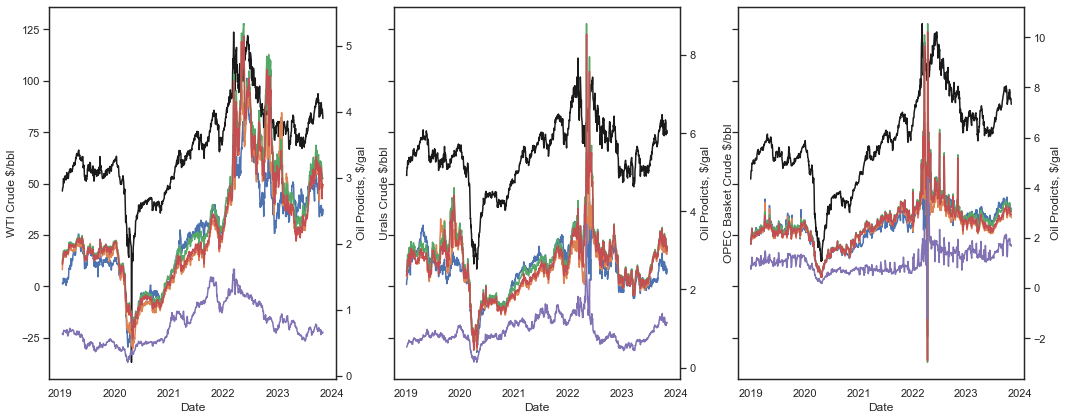

In [134]:
plot_prices([wti_df, urals_df, opec_df])

In [117]:
# Basic statistics of the dataset
get_stats([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,66.978273,2.135747,2.162939,2.340382,2.233563,0.776448
std,21.155527,0.742122,0.868190,0.934317,0.895875,0.306813
min,-36.980000,0.434000,0.407000,0.602000,0.562000,0.203000
25%,53.592500,1.650000,1.694250,1.814750,1.740500,0.513000
50%,66.050000,2.121500,1.931000,2.071500,1.978500,0.703000
75%,80.700000,2.623000,2.778500,2.906250,2.737750,1.015500
max,123.640000,4.509000,5.066000,5.339000,5.152000,1.615000
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
count,1215.000000,1214.000000,1215.000000,1213.000000,1215.000000,1214.00000


In [118]:
# Calculate returns
wti_returns_df, urals_returns_df, opec_returns_df = calc_returns([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2023-10-30,0.017026,0.031454,-0.005228,-0.001670,-0.004487,-0.021116
2023-10-27,0.036252,-0.022574,0.001752,0.006691,0.007975,0.000000
2023-10-26,-0.026034,-0.017423,0.001399,0.013626,-0.077055,0.000000
2023-10-25,0.027088,0.004536,-0.009081,-0.008197,0.089079,0.013867
2023-10-24,-0.017311,0.015599,-0.004230,0.013884,0.023272,-0.010638
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2023-10-30,-0.019261,-0.026941,-0.030667,-0.030809,-0.031008,-0.024138
2023-10-27,0.006322,-0.026059,-0.004127,-0.005298,-0.008000,-0.007067


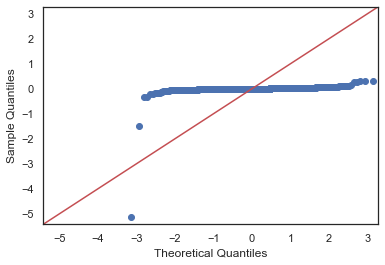

In [119]:
# Plot Q-Q plot
fig = sm.qqplot(wti_returns_df['Crude'], line='45')
plt.show()

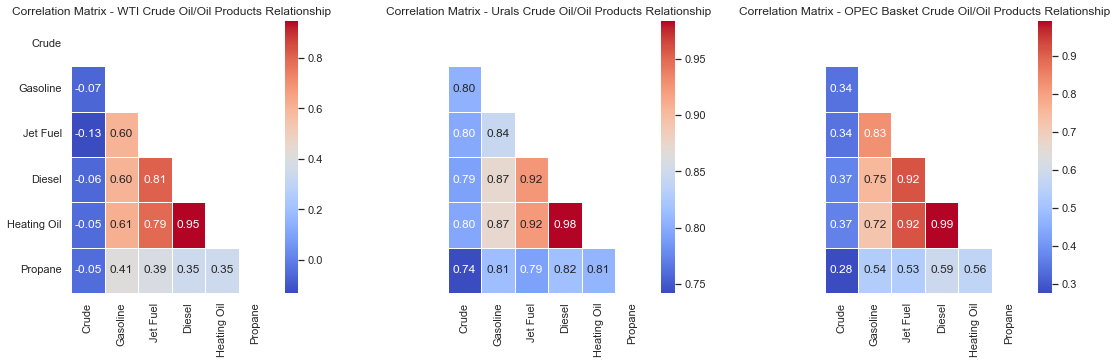

In [120]:
plot_corr_matrix([wti_returns_df, urals_returns_df, opec_returns_df])

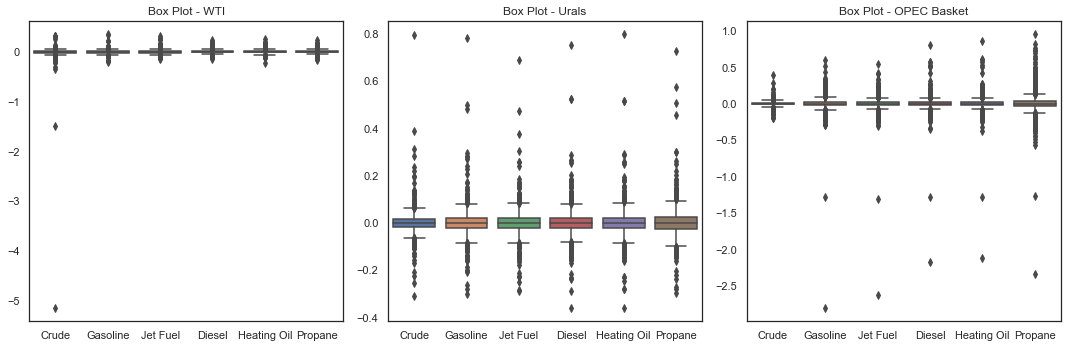

In [121]:
# Plotting blox plot to identify the outliers
box_plots([wti_returns_df, urals_returns_df, opec_returns_df])

## Stationarity test

In [152]:
adf_test([wti_returns_df, urals_returns_df, opec_returns_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
ADF Statistic,-1.727995e+01,-8.631614e+00,-1.645415e+01,-1.432117e+01,-32.480472,-34.930485
p-value,5.790251e-30,5.735240e-14,2.363129e-29,1.140612e-26,0.000000,0.000000
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
ADF Statistic,-6.150812e+00,-6.745131e+00,-7.263765e+00,-7.294375e+00,-6.471762e+00,-7.154704e+00
p-value,7.570424e-08,3.048666e-09,1.655400e-10,1.390318e-10,1.361638e-08,3.076180e-10
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
ADF Statistic,-5.335019,-9.004042e+00,-1.304935e+01,-8.132447e+00,-7.988321e+00,-8.975193e+00
p-value,0.000005,6.382668e-15,2.158172e-24,1.081136e-12,2.513743e-12,7.565252e-15


Results of the tests show our data is stationary since p-values are extremely low.

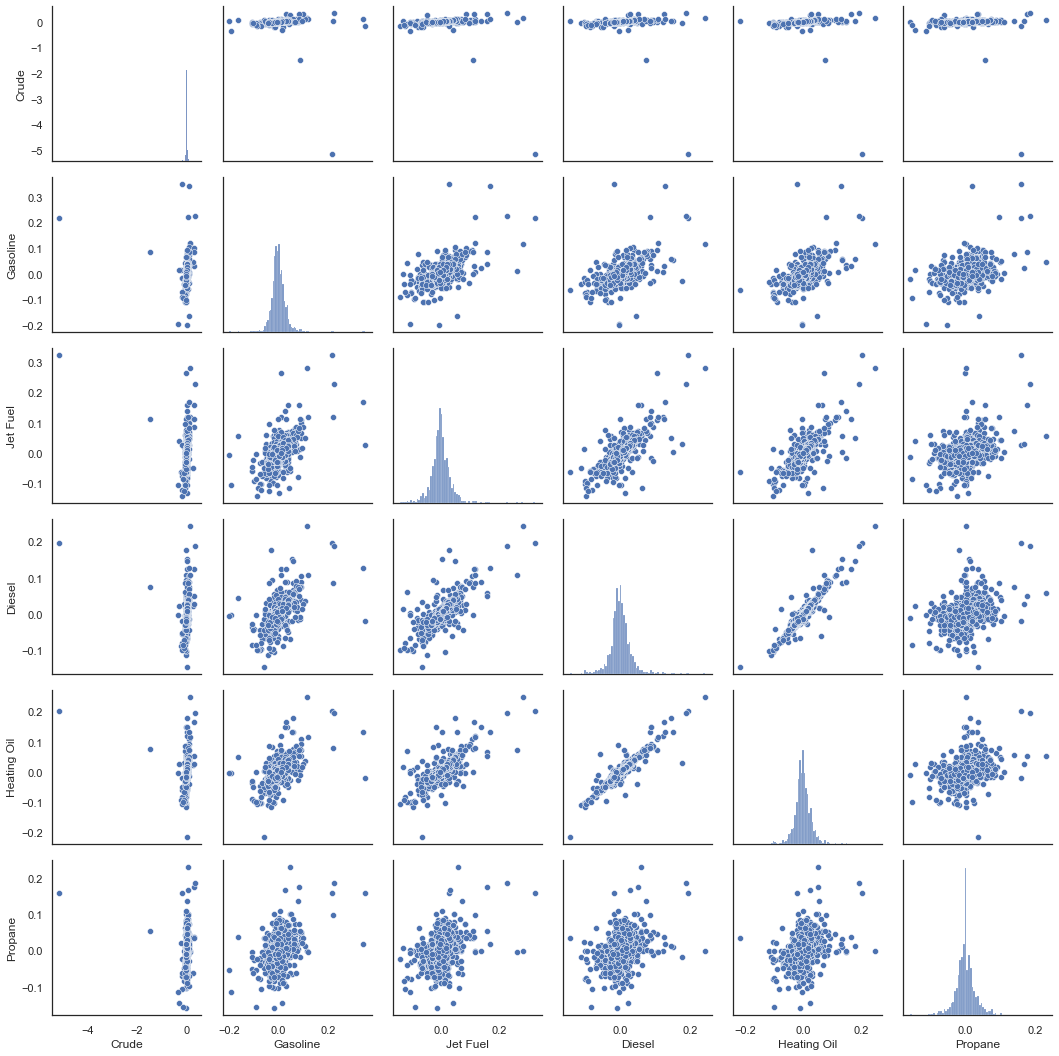

In [123]:
# Distribution of returns and scatterplots showing relationships between returns of various oil products
g = sns.PairGrid(wti_returns_df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

## Key statistical metrics

In [124]:
statistics([wti_returns_df, urals_returns_df, opec_returns_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Mean,-0.005813,0.000088,0.000160,-0.000015,0.000064,0.000479
Median,-0.001953,-0.002012,-0.001551,-0.001145,-0.001517,0.000000
Variance,0.025079,0.001144,0.001312,0.000915,0.001034,0.001026
Skewness,-28.922165,2.148141,1.564984,1.192077,0.962107,0.674353
Kurtosis,921.682091,24.109572,13.140274,9.454042,9.974272,6.949890
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Mean,0.000688,0.001291,0.001195,0.001288,0.001307,0.001047
Median,-0.002199,-0.001548,-0.001194,-0.001163,-0.001426,-0.003362
Variance,0.002127,0.003117,0.002948,0.003169,0.003278,0.003690
Skewness,4.913274,3.465453,2.403480,3.152305,3.307097,2.986225


combined!!!
legends


The distributions with a higher kurtosis have heavier tails.

In [125]:
calc_covariance([wti_returns_df, urals_returns_df, opec_returns_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Crude,0.025079,-0.000357,-0.000745,-0.000288,-0.000268,-0.000239
Gasoline,-0.000357,0.001144,0.000740,0.000617,0.000668,0.000448
Jet Fuel,-0.000745,0.000740,0.001312,0.000885,0.000926,0.000452
Diesel,-0.000288,0.000617,0.000885,0.000915,0.000920,0.000338
Heating Oil,-0.000268,0.000668,0.000926,0.000920,0.001034,0.000357
Propane,-0.000239,0.000448,0.000452,0.000338,0.000357,0.001026
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Crude,0.002127,0.002072,0.001998,0.002058,0.002102,0.002079
Gasoline,0.002072,0.003117,0.002560,0.002740,0.002789,0.002762
Jet Fuel,0.001998,0.002560,0.002948,0.002827,0.002868,0.002615


## Building ARIMA models

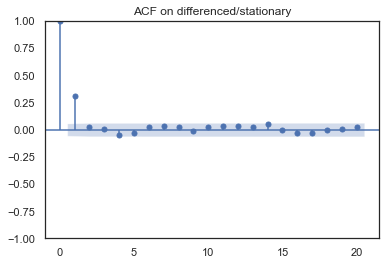

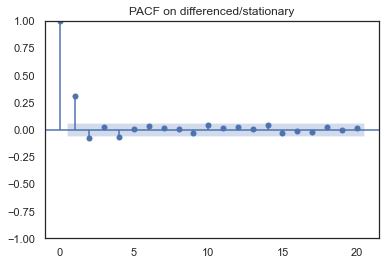

In [126]:
# Plotting ACF and PACF functions
plot_acf(wti_returns_df['Crude'], lags=20,  title='ACF on differenced/stationary')
plot_pacf(wti_returns_df['Crude'], lags=20,  method='ols', title='PACF on differenced/stationary')

plt.show()

ACF and PACF plots indicate that multiple autocorrelations are significantly non-zero. By analyzing the spikes on the graph we chose parameters for our models. As a result orders p=1 and q=1 were selected for ARIMA model since there are significant spikes at lags 1 on both plots. We have already applied differencing to crude oil data before fitting the model, therefore d parameter is zero. It's an AutoRegressive Integrated Moving Average model with a first-order autoregressive term, no differencing, and a first-order moving average term. 

In [127]:
model = ARIMA(wti_returns_df['Crude'], order=(1,0,1))
model_fit = model.fit()
summary = model_fit.summary()
table_data = summary.tables[0].data    
    
# Create a DataFrame
results_df = pd.DataFrame(table_data[1:], columns=table_data[0])

# Convert the dictionary to a DataFrame
# results_df = pd.DataFrame(results_dict)
print(results_df)

     Dep. Variable:             Crude    No. Observations:         1215
0            Model:    ARIMA(1, 0, 1)    Log Likelihood         578.782
1             Date:  Sat, 09 Dec 2023    AIC                  -1149.564
2             Time:          16:21:41    BIC                  -1129.154
3           Sample:                 0    HQIC                 -1141.880
4                              - 1215                                  
5  Covariance Type:               opg                                  


In [128]:
summarize_arima([wti_returns_df, urals_returns_df, opec_returns_df])

Let's first interpret the resulting coeficients of the model. The p-value 0.785 indicates the statistical significance of the constant. A p-value greater than the significance level commonly 0.05 suggests that the constant is not statistically different from zero. In this case, the p-value is high 0.785, indicating that the constant is not statistically significant. The autoregressive term captures the relationship between the current value of the dependent variable and its previous value. The p-value 0.727 is also far above 0.05 and thus statistically insignificant. The moving average term shows how previous forecast errors affect the current value of the dependent variable. The p-value 0.019 is less than 0.05, suggesting that the moving average term is statistically significant. We can conclude, the constant and autoregressive lag 1 term may not be statistically significant, while the moving average lag 1 term appears to be significant.

To ensure a good fit of the model we assessed log likelihood, AIC, and BIC. The AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are both statistical measures used for model selection. The AIC and BIC values provided in our output (-1149.564 for AIC and -1129.154 for BIC) are both negative. Lower AIC and BIC values, in this case, suggest that the ARIMA(1, 0, 1) model is relatively better among the considered models in terms of goodness of fit and complexity. 

The log-likelihood is a measure of how well a statistical model explains the observed data. A higher log-likelihood indicates a better fit of the model to the data. The log-likelihood value of 578.782 suggests that the model is providing a reasonable fit to the observed data.


## Principal Components Analysis

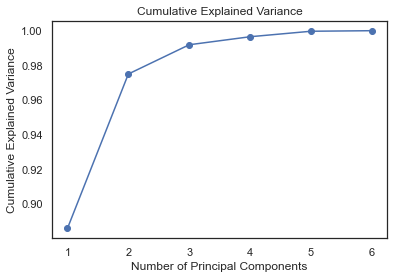

In [129]:
# Standardize the Data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(wti_df)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(data_standardized)

# Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Long Short-term Memory Model

   var1(t-1)  var2(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)   var2(t)  \
1   0.943760   0.420303   0.369639   0.447899   0.354124  0.947271  0.321878   
2   0.947271   0.321878   0.391151   0.670588   0.408841  0.935896  0.331262   
3   0.935896   0.331262   0.408992   0.014286   0.408841  0.945598  0.371266   
4   0.945598   0.371266   0.352847   0.988235   0.444775  0.937489  0.391420   
5   0.937489   0.391420   0.409657   0.836134   0.381275  0.942615  0.407183   

    var3(t)   var4(t)   var5(t)   var6(t)  
1  0.308545  0.391151  0.670588  0.408841  
2  0.307789  0.408992  0.014286  0.408841  
3  0.285336  0.352847  0.988235  0.444775  
4  0.295730  0.409657  0.836134  0.381275  
5  0.357119  0.453628  0.842017  0.448645  
(900, 1, 10) (900,) (314, 1, 10) (314,)
Epoch 1/100
13/13 - 3s - loss: 0.1218 - val_loss: 0.0650 - 3s/epoch - 246ms/step
Epoch 2/100
13/13 - 0s - loss: 0.0631 - val_loss: 0.0608 - 72ms/epoch - 6ms/step
Epoch 3/100
13/13 - 0s - loss: 0.0529 - val_loss: 0.0

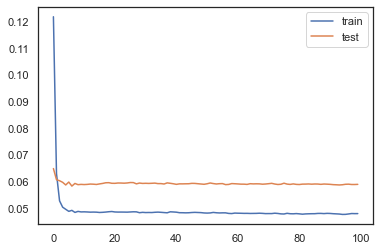

10/10 [==============================] - 0s 1ms/step


ValueError: operands could not be broadcast together with shapes (314,10) (6,) (314,10) 

In [130]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
  names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
  if i == 0:
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
  else:
    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
  agg.dropna(inplace=True)
  return agg
 
# load dataset
dataset = wti_returns_df
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 900
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network

history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)